In [1]:
import numpy as np
import cygnus_lib as cy
import matplotlib.pyplot as plt
import mylib as my
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats

from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import scipy.ndimage

%matplotlib inline
x_resolution = y_resolution = 2048
from itertools import combinations
pixelscale  = 0.125 #55e-3 #Orange 0.125 for lemonn mm/pixel

In [2]:
# run info and selection
run = 221
traccia = 0
dataSelection = 'LAB'
image = cy.swift_read_image_h5(cy.imageFile2FullPathCygnus(dataSelection, run, traccia))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1700 900


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


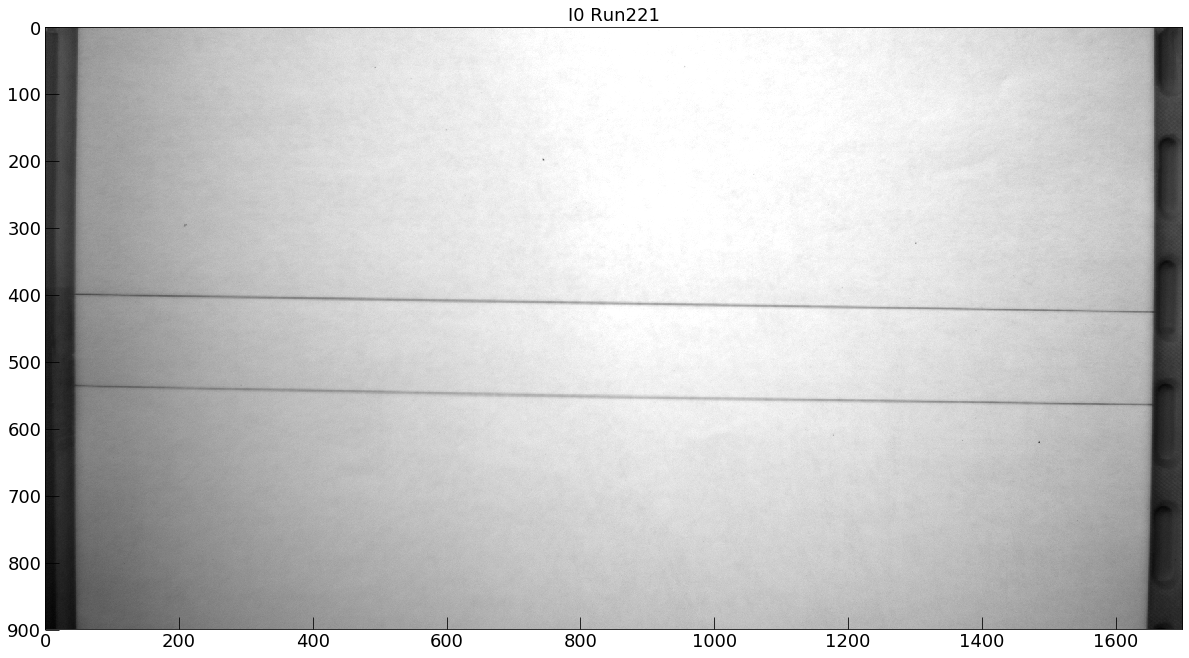

In [4]:
cy.set_atlas_style("large")
imageBare    = image[600:1500,150:1850]
x_resolution = np.size(imageBare[1,:])
y_resolution = np.size(imageBare[:,1])
print (x_resolution, y_resolution)
plt.title("I%d Run%d" % (traccia, run))
plt.imshow(imageBare, cmap="gray")
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


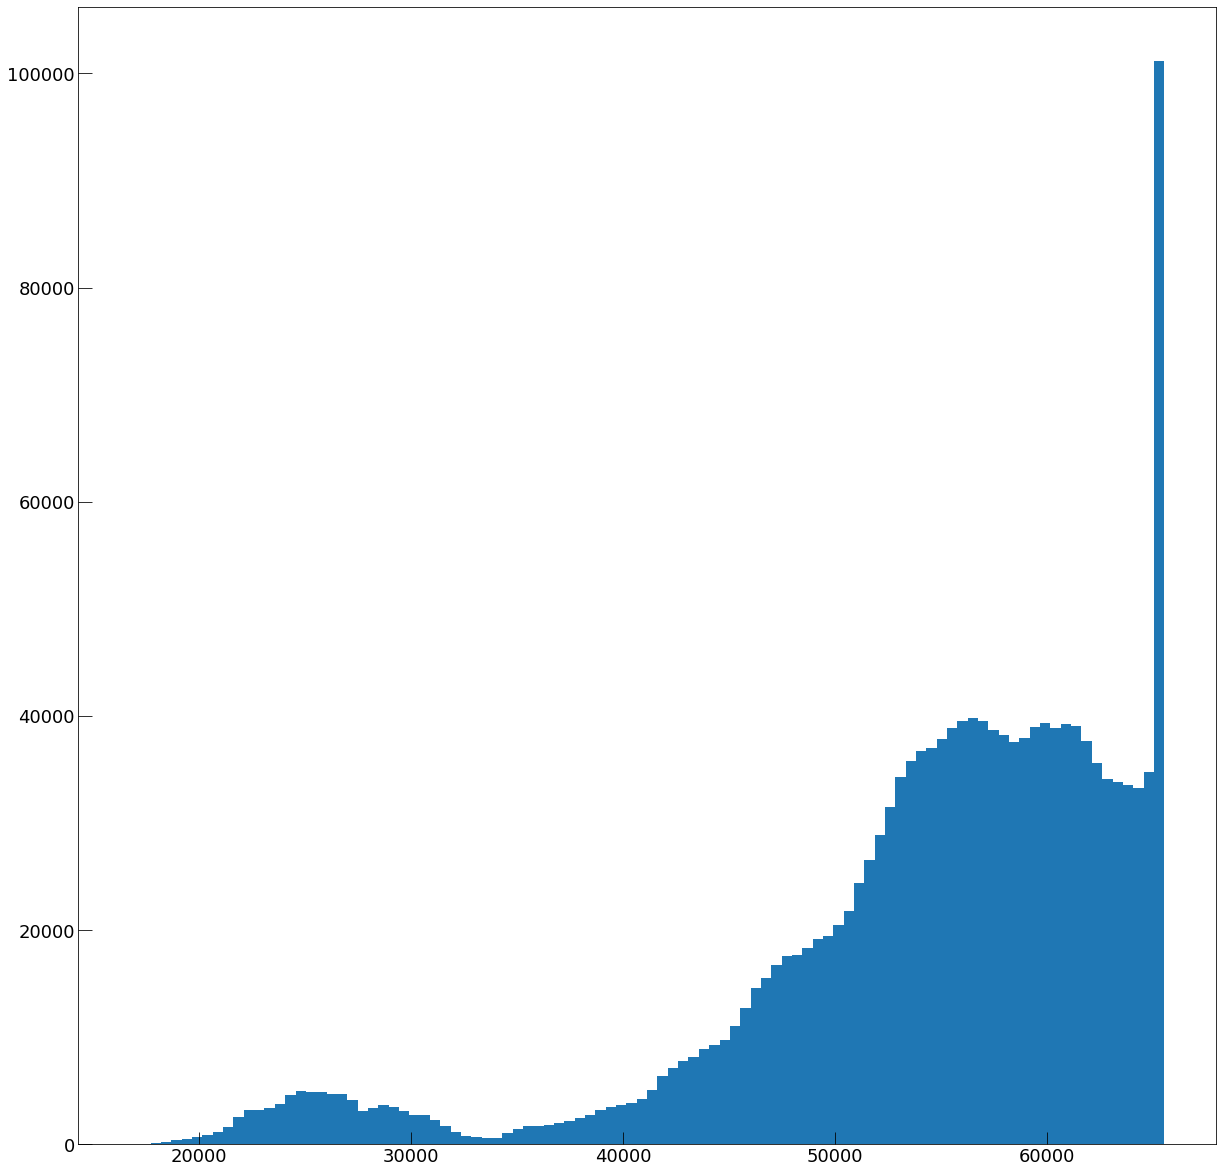

In [5]:
plt.hist(imageBare.ravel(), bins=100)
plt.plot()
plt.show()

Tmin: 1.41, Tmax: 1.73, Tstep: 100$
y0: 398.66, y1: 428.34, T: 1.59 DT:-1.75e-02
y0: 536.72, y1: 566.39, T: 1.59 DT:-1.75e-02
y0: 897.73, y1: 895.04, T: 1.57 DT:1.59e-03
y0: 897.73, y1: 895.04, T: 1.60 DT:-3.33e-02
y0: 897.73, y1: 895.04, T: 1.69 DT:-1.22e-01
y0: 897.73, y1: 895.04, T: 1.72 DT:-1.44e-01
y0: 897.73, y1: 895.04, T: 1.62 DT:-5.24e-02
y0: 897.73, y1: 895.04, T: 1.65 DT:-7.46e-02
y0: 897.73, y1: 895.04, T: 1.65 DT:-8.09e-02


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


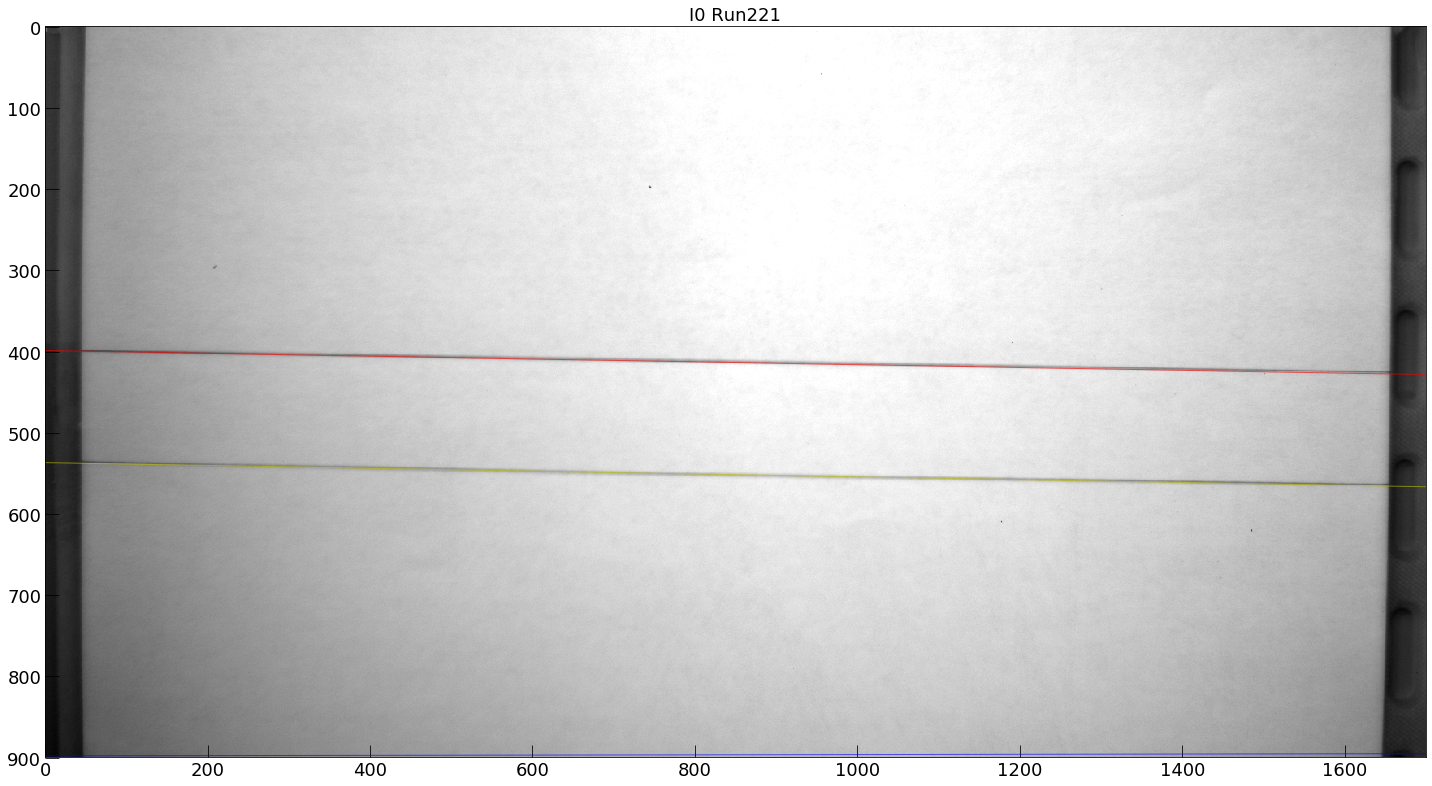

In [6]:
c = ['-r', '-y', '-b', '-g']
# optimized for horizontal track in dtheta
dtheta=np.pi/20
tvt = np.linspace(np.pi/2-dtheta, np.pi/2+dtheta, num=100)
print ("Tmin: %.2f, Tmax: %.2f, Tstep: %d$" % (np.min(tvt), np.max(tvt), np.size(tvt)))
fig, ax = plt.subplots()
#image = imageBare <50000
image = imageBare <43900
h, theta, d = hough_line(image, tvt)
ax.imshow(imageBare, cmap="gray")
k = 0
for _, angle0, dist0 in zip(*hough_line_peaks(h, theta, d)):
    if np.abs(np.pi/2-angle0) <3e-2: ##################### attenzine plotta solo tracce orizzontali
        y0 = (dist0 - 0 * np.cos(angle0)) / np.sin(angle0)
        y1 = (dist0 - image.shape[1] * np.cos(angle0)) / np.sin(angle0)
        ax.plot((0, image.shape[1]-1), (y0, y1), c[np.fmod(k,4)], alpha=0.6)
        k +=1
    print("y0: %.2f, y1: %.2f, T: %.2f DT:%.2e" % (y0, y1,angle0, np.pi/2-angle0))
h0 = []
a0 = []
d0 = []
good = k
h0, a0, d0 = hough_line_peaks(h, theta, d)
plt.tight_layout()
plt.title("I%d Run%d" % (traccia, run))
plt.show()

1.0000e+00
1.0000e+00
-9.0909e-02


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


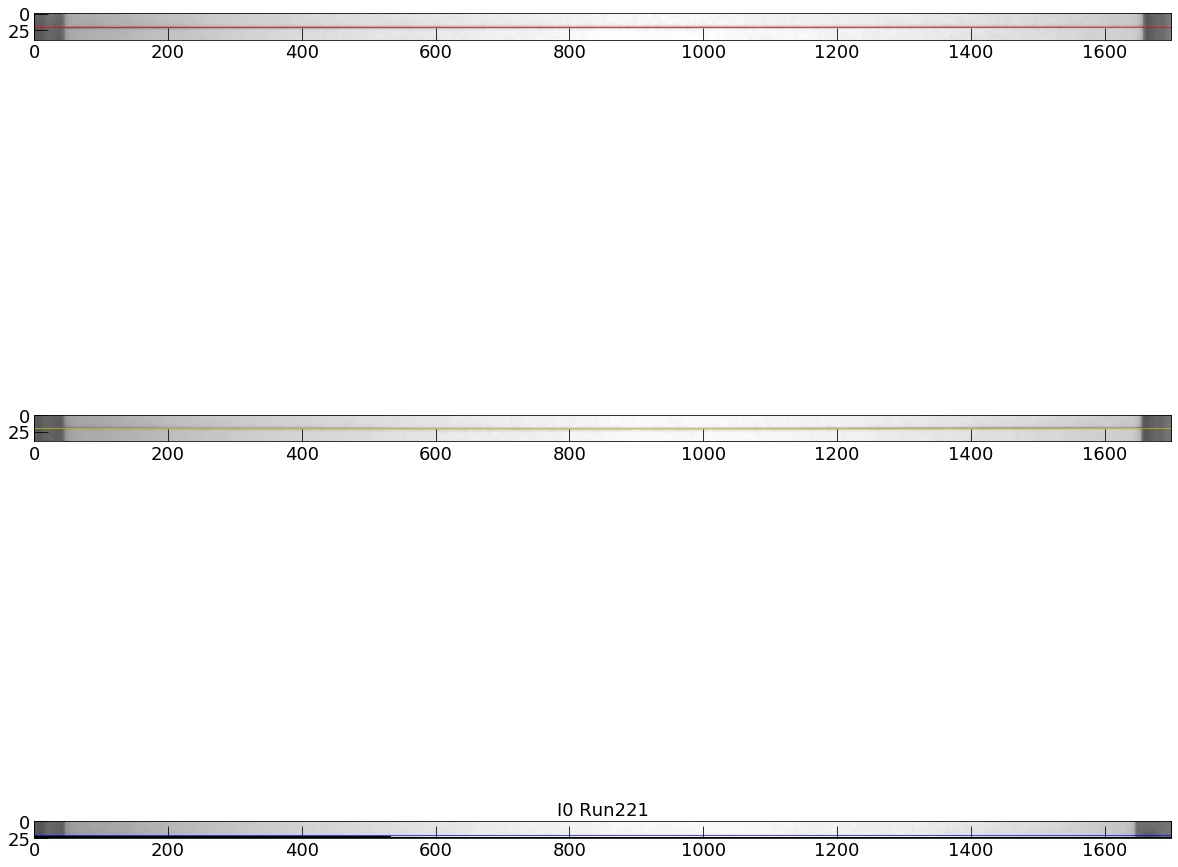

In [7]:
fig, ax = plt.subplots(good,1)
x1 = x_resolution
x0  = 0
dy0 = 20
TrInfo = []
jj=0
for i in range(0, len(a0)):
    img   = imageBare
    if np.abs(np.pi/2-a0[i]) <3e-2: ##################### attenzine seleziona solo tracce orizzontali
        
        y0 = (d0[i] - x0 * np.cos(a0[i])) / np.sin(a0[i])
        y1 = (d0[i] - x1 * np.cos(a0[i])) / np.sin(a0[i])
        theta  = np.arctan((y1-y0)/(x1-x0))
        xP = np.int(np.abs((y0-dy0)*np.sin(theta)))
        if theta<0:
            yP = np.int(y0*np.cos(theta))
        else:
            yP = np.int(y1*np.cos(theta))
        theta = theta*(180.0/np.pi)
        print ("%.4e" % theta)
        imgR  = scipy.ndimage.interpolation.rotate(img, theta)
        #
        TrInfo.append([imgR[yP-dy0:yP+dy0,xP:x_resolution+xP], xP, yP, theta, dy0])
        #TrInfo.append([img[yP-dy0:yP+dy0,xP:x_resolution+xP], xP, yP, theta, dy0])
        #
        if good<=1:
            ax.imshow(TrInfo[jj][0],  cmap="gray")
            ax.plot((0, x_resolution-1), (dy0, dy0), c[np.fmod(jj,4)], alpha=0.7)
        else:
            ax[jj].imshow(TrInfo[jj][0],  cmap="gray")
            ax[jj].plot((0, x_resolution-1), (dy0, dy0), c[np.fmod(jj,4)], alpha=0.7)
        jj+=1
plt.title("I%d Run%d" % (traccia, run))
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


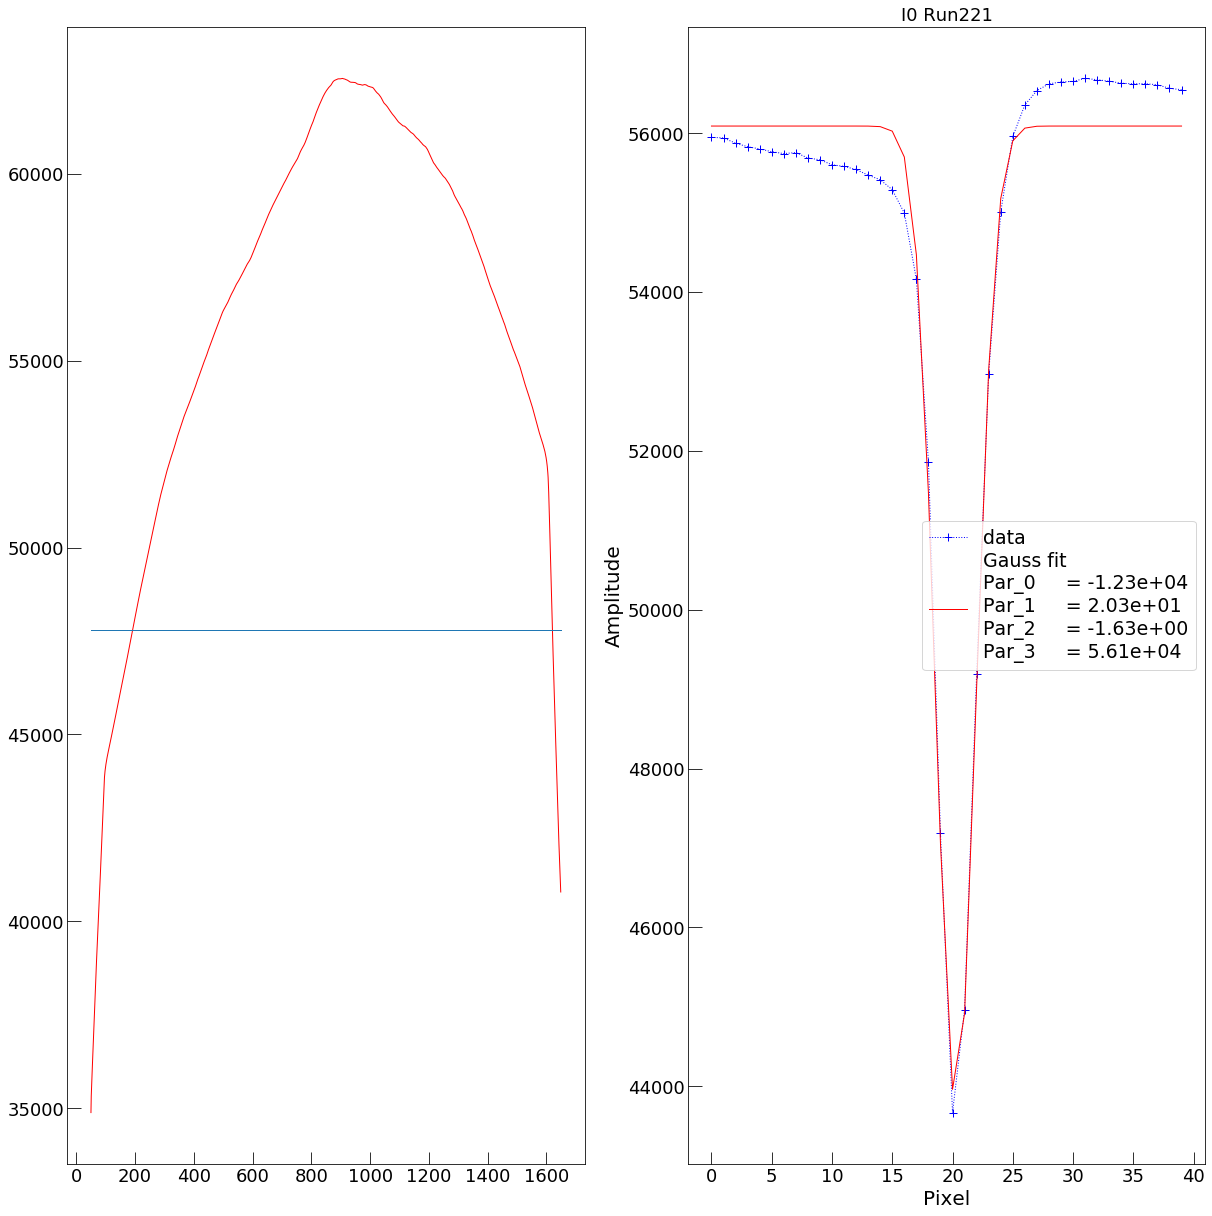

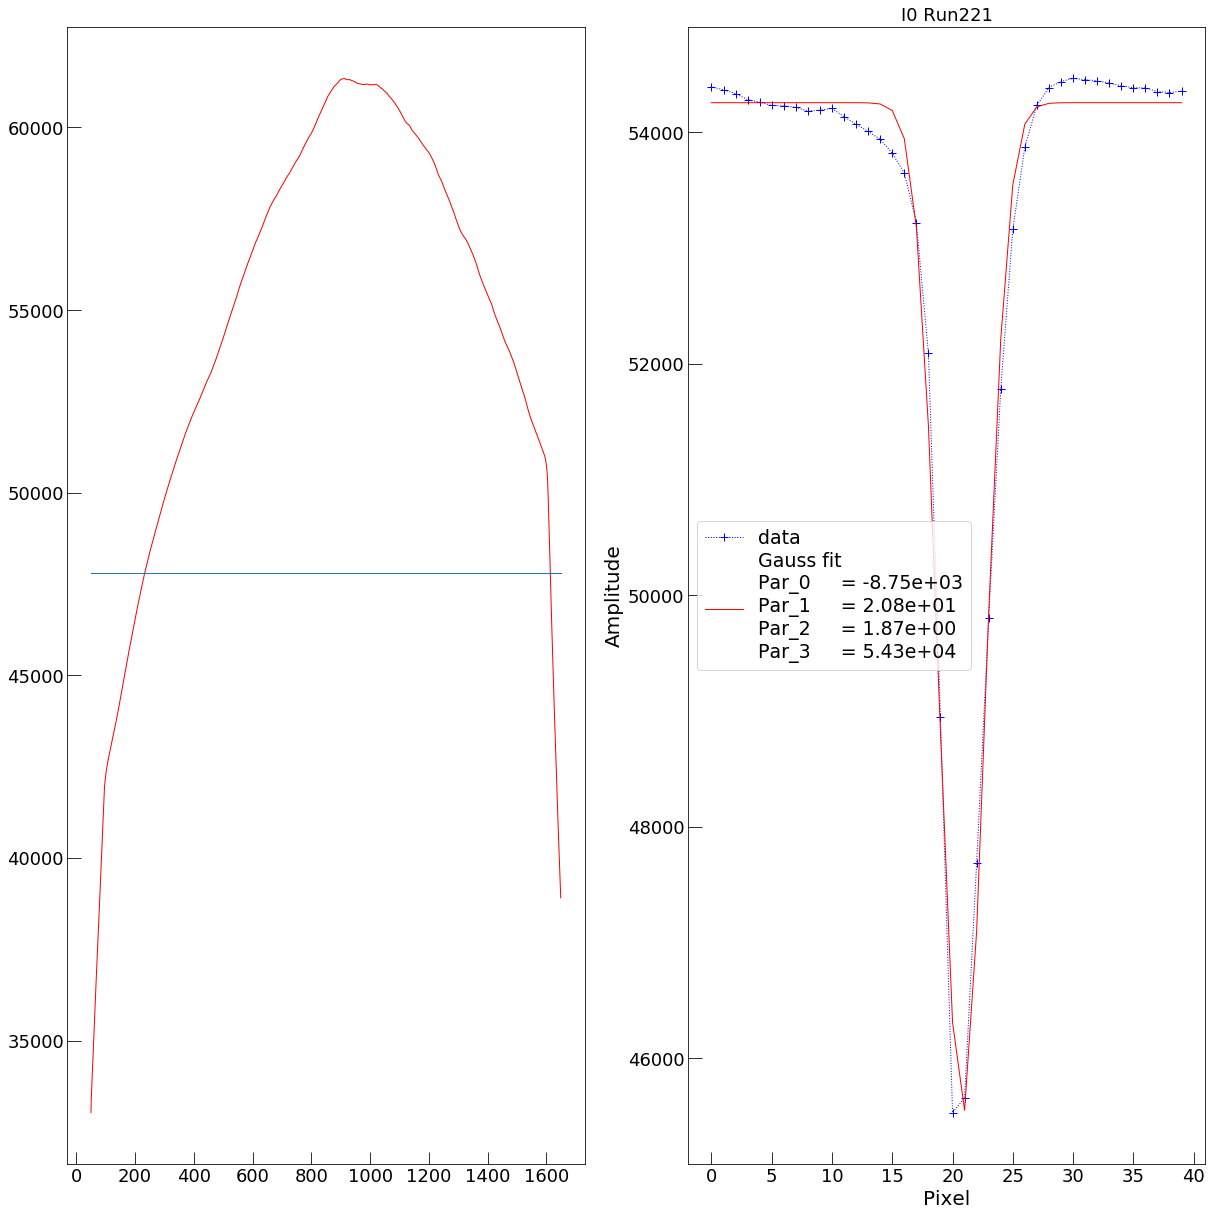

Fitting error...


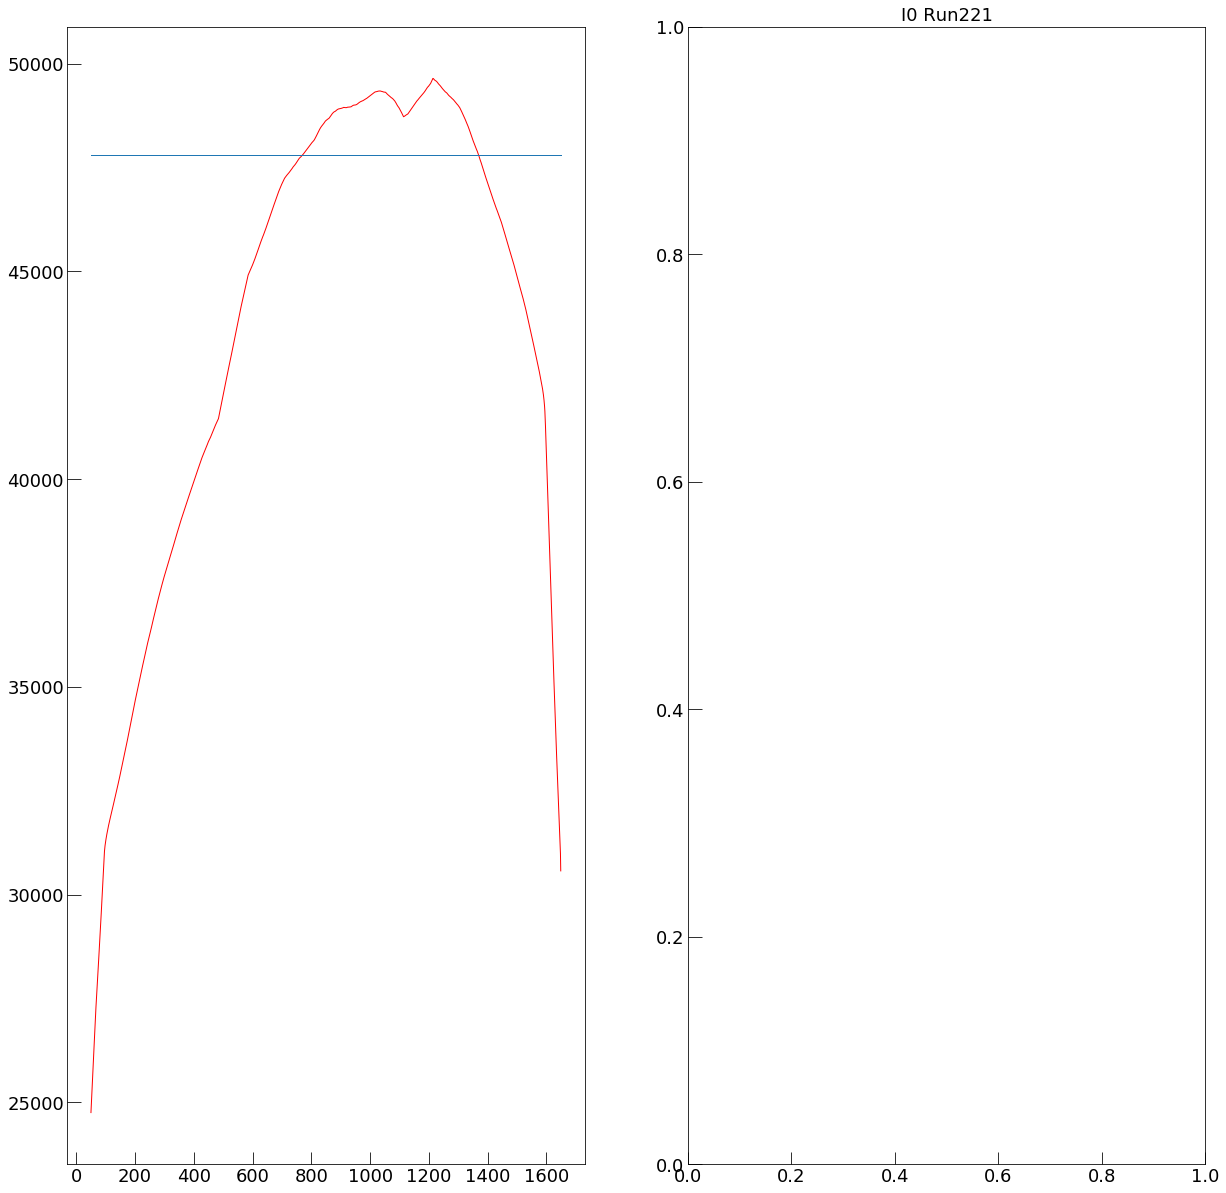

In [8]:
for i in range(0, len(TrInfo)):
    fig, ax = plt.subplots(1,2)
    XprojTh    = 47800
    #
    Xproj      = np.mean(TrInfo[i][0], axis=0)
    Yproj      = np.mean(TrInfo[i][0], axis=1)
    x=np.arange(0, x_resolution)
    #
    XprojSmoot = my.smooth(Xproj,100)[50:x_resolution-50] # valori scelti per tagliare le code e il pixel sempre on ch ~ 2000
    # trova primo e ultimo minimo data la soglia
    ax[0].plot(x[50:x_resolution-50], XprojSmoot, 'r-', label='Smoot')
    #XprojThArr = my.OverTh2Array(XprojSmoot, XprojTh)
    XprojThArr = my.UnderTh2Array(XprojSmoot, XprojTh)
    #ax[0].plot(x[50:x_resolution-50], Xproj[50:x_resolution-50], 'r-', label='Smoot')
    ax[0].plot((50,x_resolution-50), (XprojTh, XprojTh))
    xThs = XprojThArr[0][0]
    xThe = XprojThArr[len(XprojThArr)-1][0]
    try:
        x=np.arange(0, 2*dy0)
        x0 = dy0
        y0 = np.mean(Yproj)
        s0 = dy0*0.2
        a0 = max(Yproj)-y0
        popt,pcov = curve_fit(my.Gauss, x, Yproj, p0=[a0, x0, s0, y0])
        ax[1].plot(x, Yproj, 'b+:', label='data')
        ax[1].plot(x, my.Gauss(x, *popt), 'r-',
                   label='Gauss fit   \nPar_0     = %.2e\nPar_1     = %.2e\nPar_2     = %.2e\nPar_3     = %.2e' %
                   (popt[0], popt[1], popt[2], popt[3]))
        ax[1].set_xlabel('Pixel')
        ax[1].set_ylabel('Amplitude')
        plt.legend()
    except:
        print ("Fitting error...")

    plt.title("I%d Run%d" % (traccia, run))
    plt.show()
    TrInfo[i] = np.append(TrInfo[i], (xThs, xThe, popt[0], popt[1], popt[2], popt[3]))

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


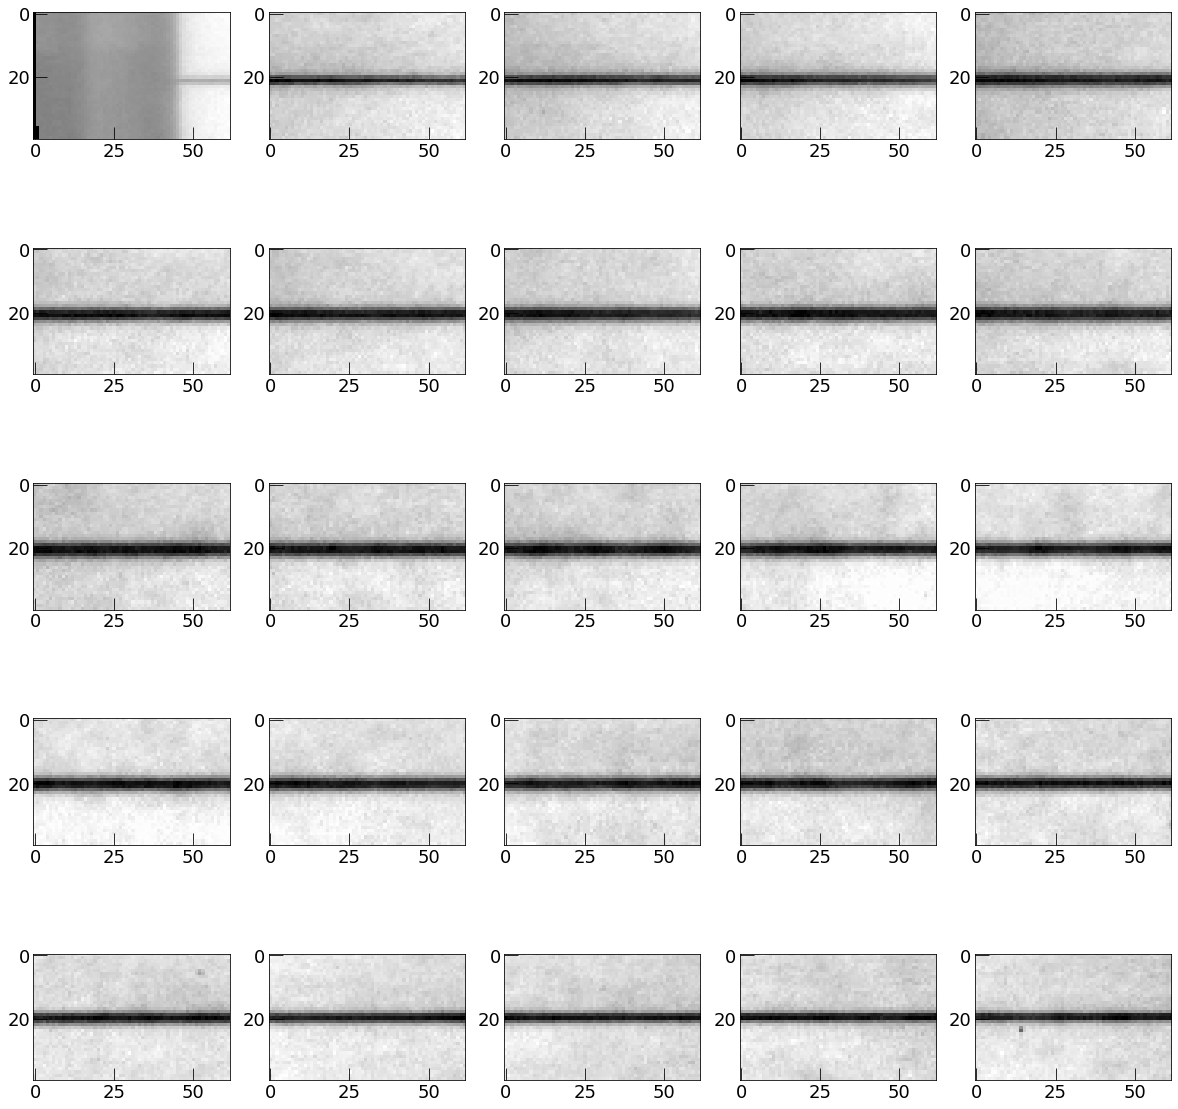

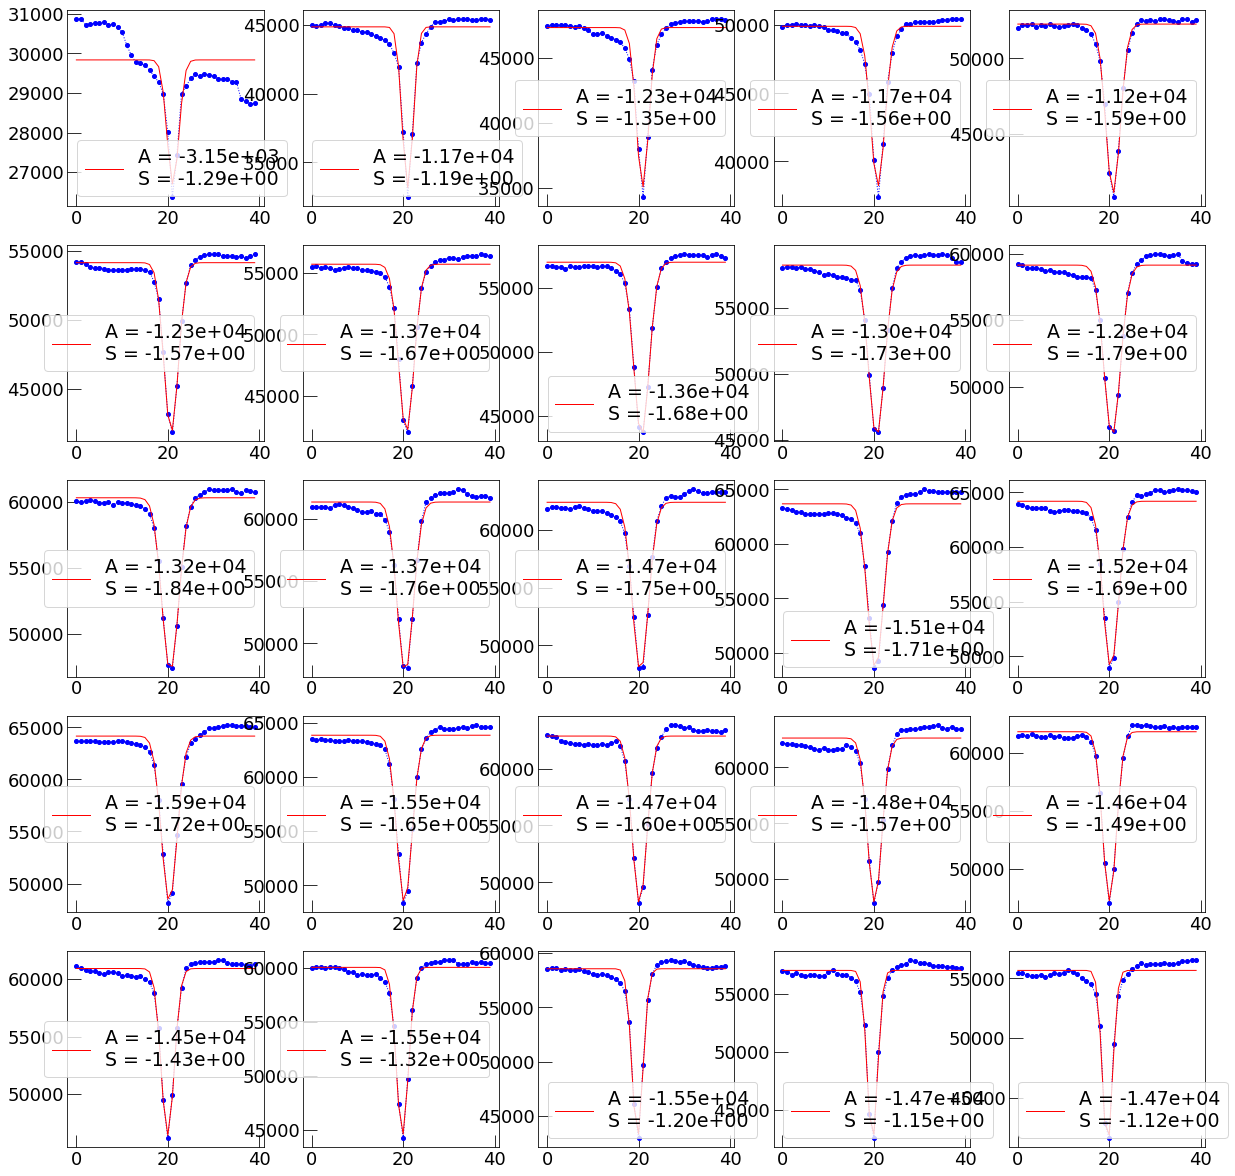

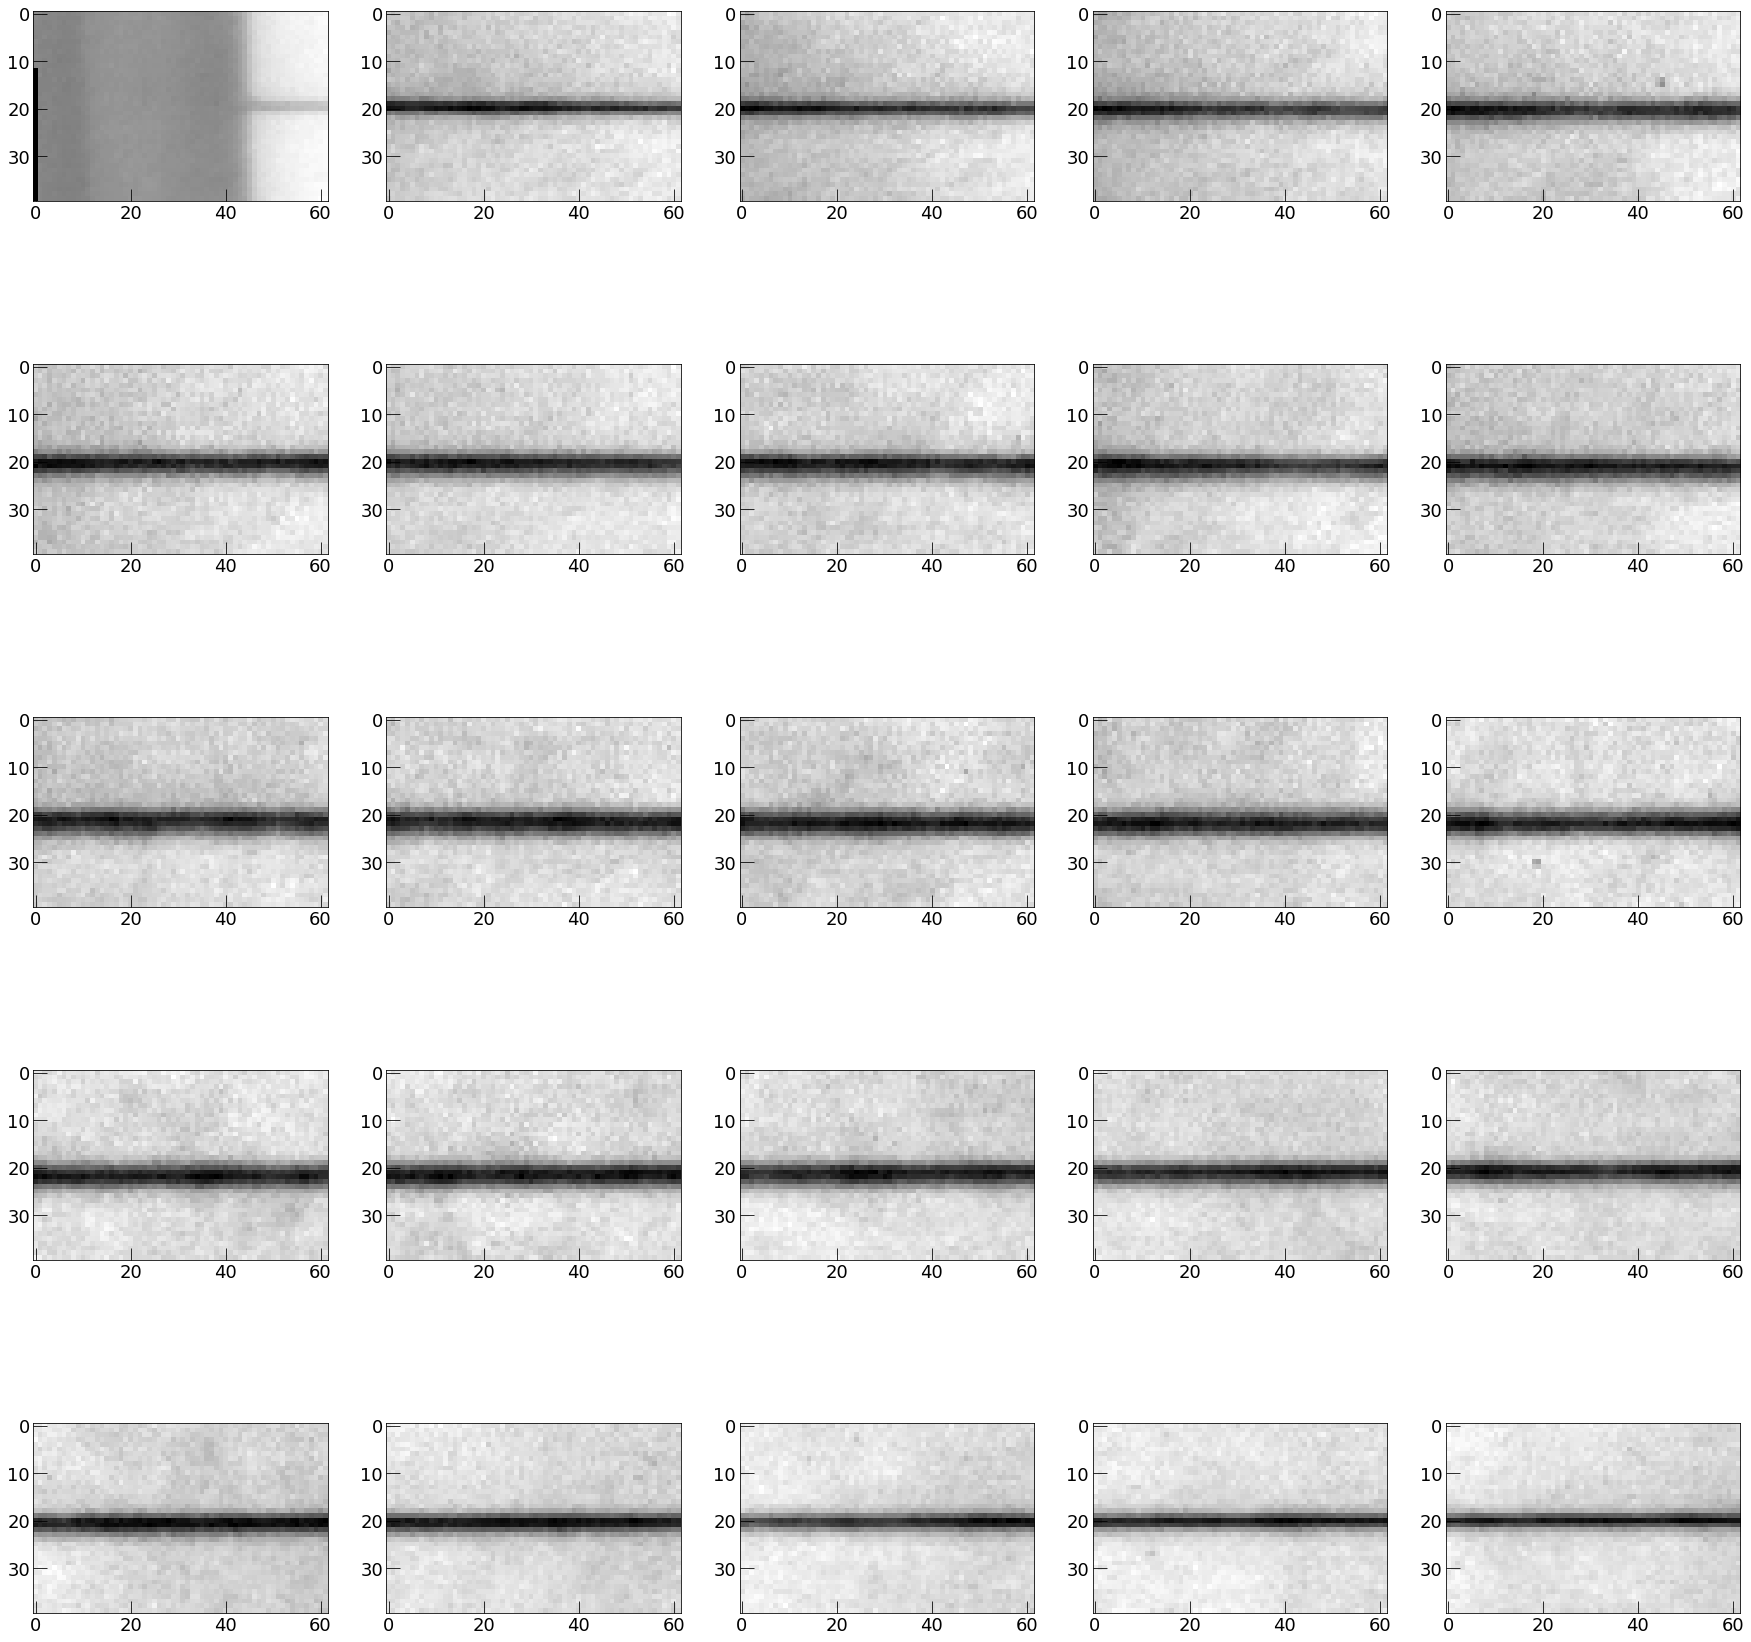

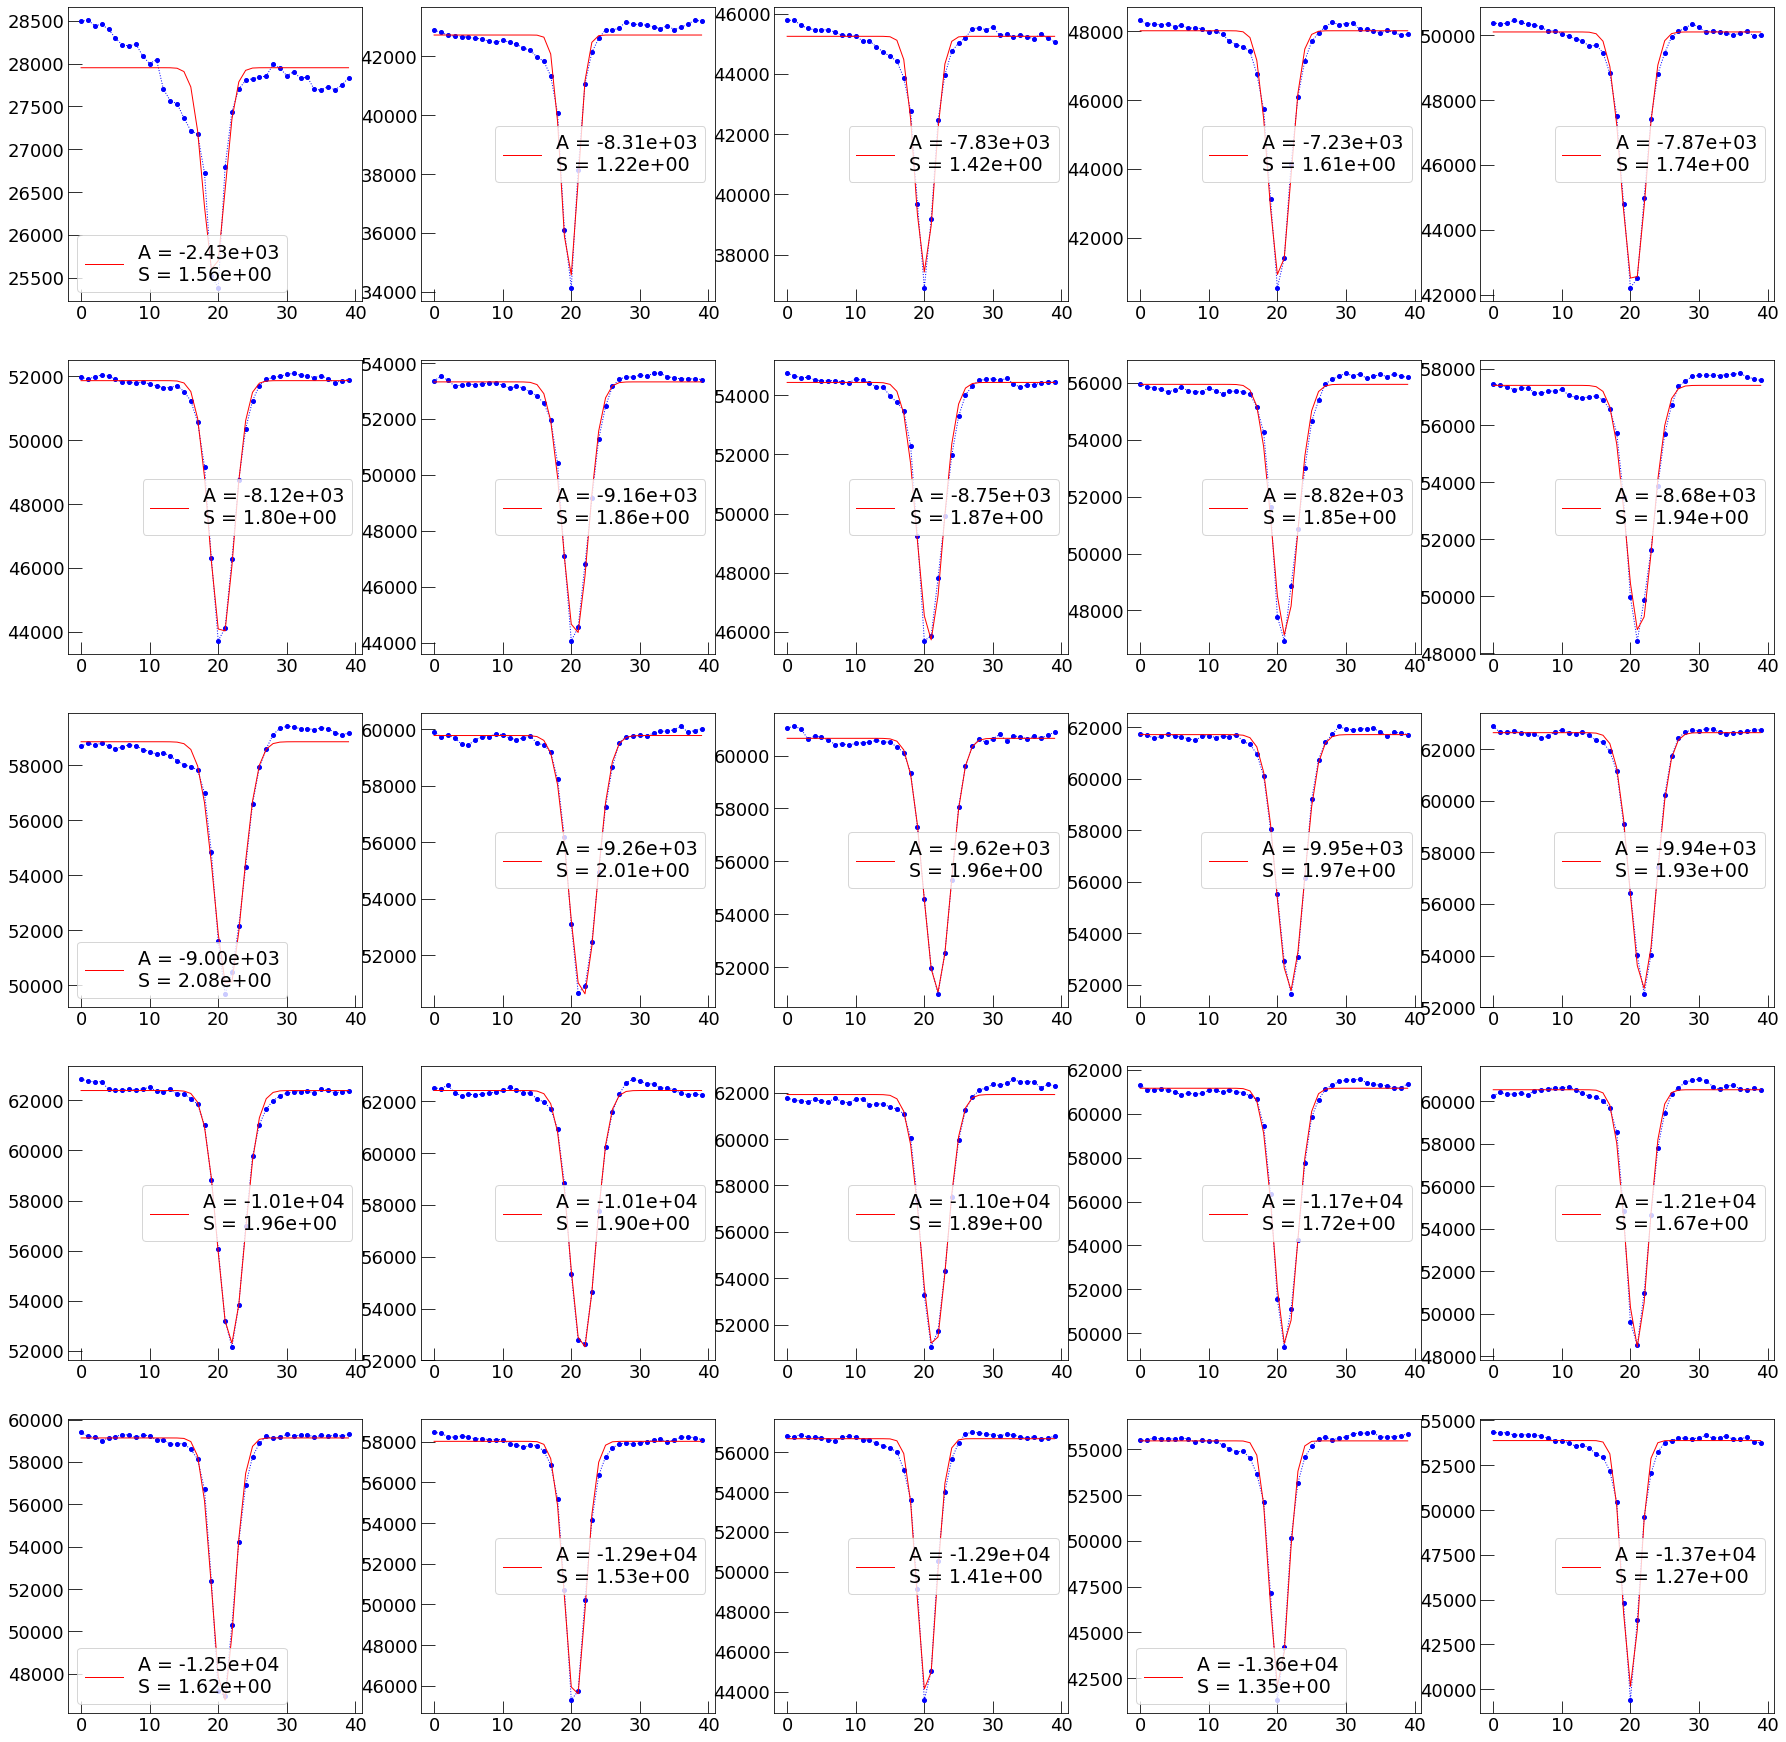

In [9]:
# for i in range(0, len(TrInfo)):
#Track2Study = 6
Track2Study = 2
nslide    = 5
fitVar    = np.ndarray((Track2Study, (nslide*nslide), 4), dtype=np.float64)
for i in range(0, Track2Study):
    slide     = np.int((TrInfo[i][6]-TrInfo[i][5])/(nslide*nslide))
    f, axarr  = plt.subplots(nslide, nslide)
    e_slide   = np.int(TrInfo[i][5])
    xs = np.arange(0, dy0*2)
    for j in range(0, nslide):
        for k in range(0, nslide):
            s_slide = e_slide 
            e_slide = s_slide + slide
            axarr[j, k].imshow(TrInfo[i][0][0:,s_slide:e_slide],  cmap="gray")

    plt.show()
    f, axarr  = plt.subplots(nslide, nslide)
    e_slide   = np.int(TrInfo[i][5])
#
    ji        = 0
#
    plt.rcParams['figure.figsize'] = (30.0, 30.0)
    for j in range(0, nslide):
        for k in range(0, nslide):
            s_slide = e_slide 
            e_slide = s_slide + slide
            y  = np.mean(TrInfo[i][0][0:,s_slide:e_slide], axis=1)
            a0 = TrInfo[i][7]
            x0 = TrInfo[i][8]
            s0 = TrInfo[i][9]
            y0 = TrInfo[i][10]
            try:
                popt,pcov = curve_fit(my.Gauss, xs, y, p0=[a0, x0, s0, y0])
                perr = np.sqrt(np.diag(pcov))
                # print perr
            except:
                print("Unable to fit data...")

            axarr[j, k].plot(xs, y, 'b:.')
            axarr[j, k].plot(xs, my.Gauss(xs, *popt), 'r-', label='A = %.2e\nS = %.2e' % (popt[0], popt[2]))
            axarr[j, k].legend()
            fitVar[i, ji,] = popt
            ji+=1
    plt.show()

[]

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


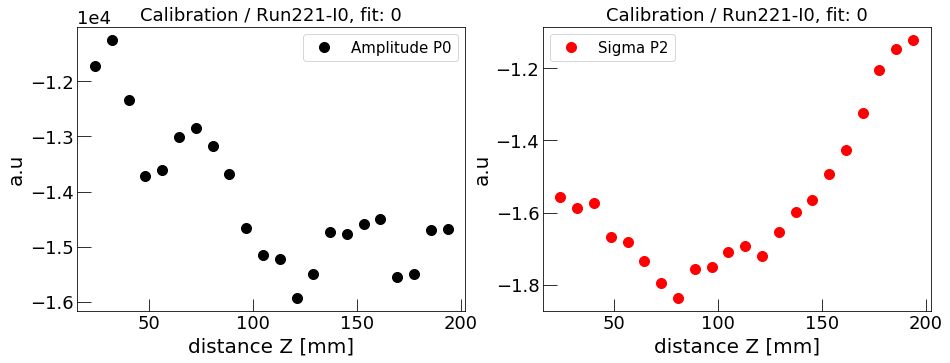

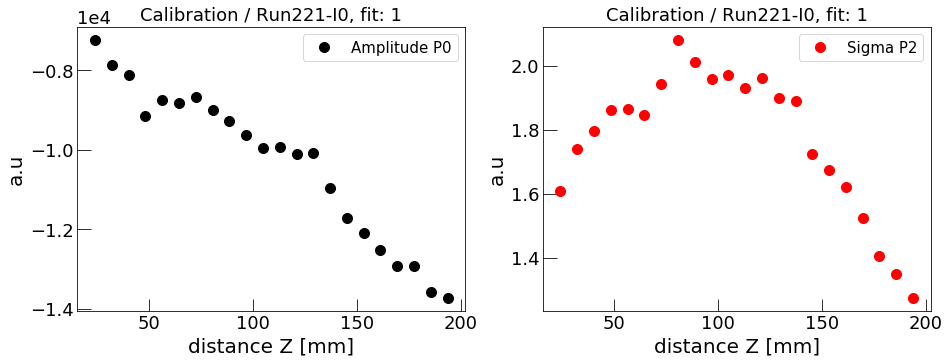

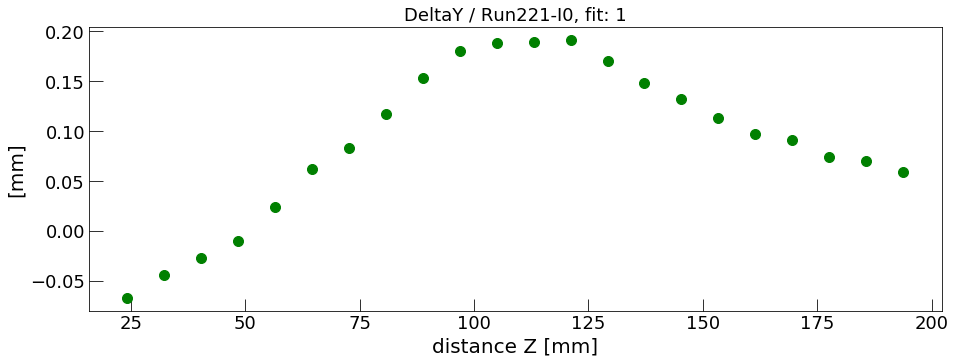

In [10]:
title = "Calibration"
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams["font.size"] = "18"
x = np.linspace(0, nslide*nslide*0.125*slide, nslide*nslide)
for i in range(0, Track2Study):
    #for j in range(0, nslide*nslide):
    #    print fitVar[i, j,2]
    fig, ax = plt.subplots(1,2)
    y = fitVar[i,:, 0]
    ax[0].set_xlabel('distance Z [mm]')
    ax[0].set_ylabel('a.u')
    ax[0].plot(x[3:], y[3:], 'k.',  markersize=20, label="Amplitude P0")
    ax[0].legend(loc=0, prop={'size':'small'})
    #ax[0].set_ylim((-18000,-7000))
    ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[0].set_title("%s / Run%d-I%d, fit: %d" %(title, run, traccia, i))
    y = fitVar[i,:, 2]
    ax[1].set_xlabel('distance Z [mm]')
    ax[1].set_ylabel('a.u')
    ax[1].plot(x[3:], y[3:], 'r.',  markersize=20, label="Sigma P2")
    ax[1].legend(loc=0, prop={'size':'small'})
    #ax[1].set_ylim((-17000,-7000))
    ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax[1].set_title("%s / Run%d-I%d, fit: %d" %(title, run, traccia, i))
fig, ax[0] = plt.subplots()
title = "DeltaY"
ax[0].set_xlabel('distance Z [mm]')
ax[0].set_ylabel('[mm]')
y = (fitVar[1,:, 1]-fitVar[0,:, 1])*0.125
ax[0].plot(x[3:], y[3:], 'g.',  markersize=20, label="P1(0)-P1(1)")
ax[0].set_title("%s / Run%d-I%d, fit: %d" %(title, run, traccia, i))
plt.plot()